In [13]:
import warnings
warnings.filterwarnings('ignore')

# Simulation of planet gravitational dynamics

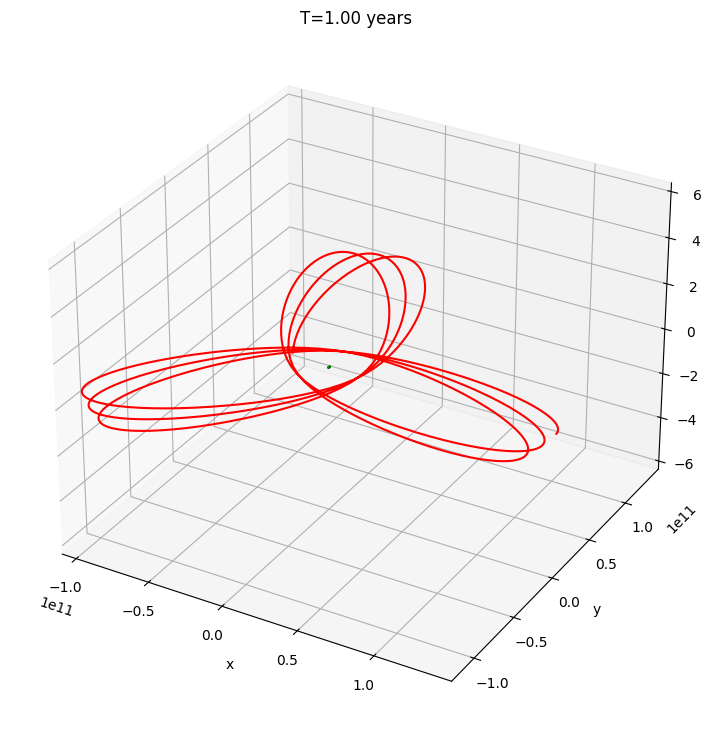

Simulation completed in 7.64 seconds


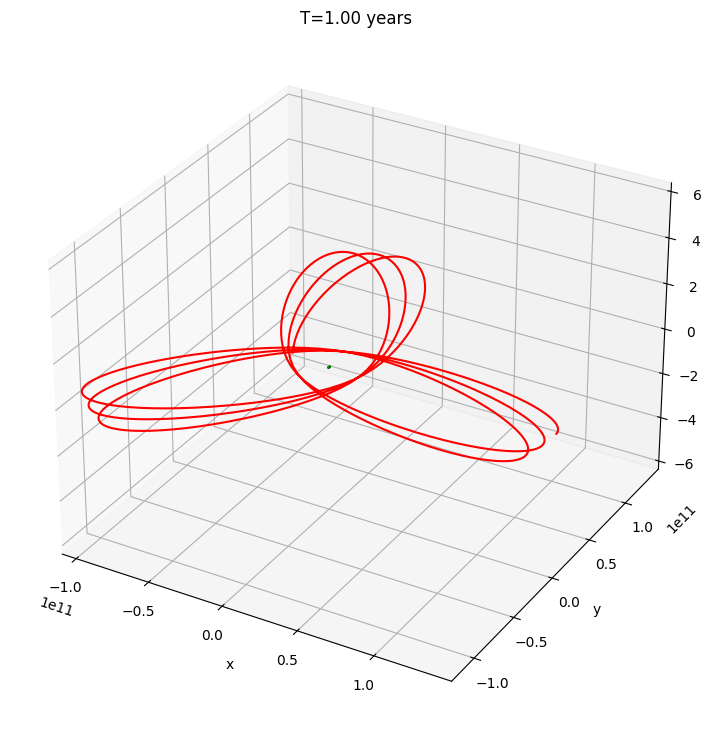

In [14]:
import sys
sys.path.insert(0, '/Users/jordi/Documents/jordi/Programming/github_dev/Planet-dynamics')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
import timeit

# Import from src modules
from src.constants import M_earth, R_earth, M_sun, R_sun, D_earth_sun, D_earth_moon, V_earth, G
from src.models.planet import Planet, static_sun, random_sun, real_earth, random_earth
from src.main import planet_dynamics
from src.visualization.plots import colors

# Run the simulation using the main.py planet_dynamics function
time_horizon = 1.0  # in years
time_delta = 0.5  # in days


planets = [static_sun("1"), real_earth("2")]
#planets = [random_sun("1"), random_sun("2"), random_earth("3"), random_earth("4")]
#planets = [Planet("1", mass=M_earth, x=0.0), Planet("2", mass=M_earth, y=1000000.0)]

# Run simulation with plotting enabled
start = timeit.default_timer()
planet_dynamics(planets=planets, time_horizon=time_horizon, time_step=time_delta, make_plot=True)
stop = timeit.default_timer()
print(f"Simulation completed in {stop - start:.2f} seconds")